# Strategies to optimize baryonic correction factor in `predict_with_baryons()` function in TabCorr

1) Upper limit of integration set past r_max to 100Mpc/h

In [14]:
import numpy as np

from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

import pandas as pd

import time

from scipy.interpolate import splrep, splev
from scipy.integrate import quad

from halotools.sim_manager import UserSuppliedHaloCatalog, UserSuppliedPtclCatalog,FakeSim, CachedHaloCatalog
from halotools.mock_observables import delta_sigma, wp, return_xyz_formatted_array
from halotools.empirical_models import NFWProfile
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.empirical_models import AssembiasZheng07Cens, AssembiasZheng07Sats, TrivialPhaseSpace, NFWPhaseSpace
from halotools.utils import add_halo_hostid
from halotools.mock_observables.surface_density.surface_density_helpers import annular_area_weighted_midpoints

import baryonification as bfc
# from baryonification.useful_functions import DeltaSigmas_from_density_profile, cvir_fct

from tabcorr import TabCorr

from astropy.cosmology import Planck15

from colossus.cosmology import cosmology
from colossus.halo import concentration

In [2]:
redshift = (1./0.65650)-1. #z=0.523
Lbox = 1000. #Mpc/h

In [3]:
# Now, we're ready to calculate correlation functions for a specific model.
HOD_model = PrebuiltHodModelFactory('zheng07', redshift = redshift, cosmology=Planck15, populate=False,
                                         secondary_haloprop_key='halo_nfw_conc')



In [4]:
def hod_model_from_params(params, HOD_model):
    
    HOD_model.param_dict['logMmin'] = params[0]
    HOD_model.param_dict['sigma_logM'] = params[1]
    HOD_model.param_dict['logM0'] = params[2]
    HOD_model.param_dict['logM1'] = params[3]
    HOD_model.param_dict['alpha'] = params[4]
    
    return HOD_model

In [5]:
HOD_params = [13.031,0.38,13.27,14.08,0.76] #params from https://ui.adsabs.harvard.edu/abs/2014MNRAS.444..476R/abstract

HOD_model = hod_model_from_params(HOD_params, HOD_model)

In [6]:
rbin = annular_area_weighted_midpoints(np.logspace(-1, 1, 20))
rbin

array([0.1145377 , 0.14595252, 0.18598365, 0.23699431, 0.30199592,
       0.38482584, 0.49037395, 0.62487125, 0.79625781, 1.01465141,
       1.29294491, 1.64756735, 2.09945387, 2.67528154, 3.40904435,
       4.34405994, 5.53552692, 7.05378349, 8.98845985])

In [7]:
halotab = TabCorr.read('mdpl2_tabCorr_DS.hdf5')

/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [32]:
def predict_with_baryons(halotab, hod_model, baryon_model_params, separate_gal_type=False):
        r"""
        Predicts the number density and correlation function for a certain
        model.

        Parameters
        ----------
        model : HodModelFactory
            Instance of ``halotools.empirical_models.HodModelFactory``
            describing the model for which predictions are made.

        separate_gal_type : boolean, optional
            If True, the return values are dictionaries divided by each galaxy
            types contribution to the output result.

        Returns
        -------
        ngal : numpy.array or dict
            Array or dictionary of arrays containing the number densities for
            each galaxy type stored in halotab.gal_type. The total galaxy number
            density is the sum of all elements of this array.

        xi : numpy.array or dict
            Array or dictionary of arrays storing the prediction for the
            correlation function.
        """
        print('UPDATED')
        try:
            assert (sorted(hod_model.gal_types) == sorted(
                    ['centrals', 'satellites']))
        except AssertionError:
            raise RuntimeError('The model instance must only have centrals ' +
                               'and satellites as galaxy types. Check the ' +
                               'gal_types attribute of the model instance.')

        try:
            assert (hod_model._input_model_dictionary['centrals_occupation']
                    .prim_haloprop_key == halotab.attrs['prim_haloprop_key'])
            assert (hod_model._input_model_dictionary['satellites_occupation']
                    .prim_haloprop_key == halotab.attrs['prim_haloprop_key'])
        except AssertionError:
            raise RuntimeError('Mismatch in the primary halo properties of ' +
                               'the model and the TabCorr instance.')

        try:
            if hasattr(hod_model._input_model_dictionary['centrals_occupation'],
                       'sec_haloprop_key'):
                assert (hod_model._input_model_dictionary['centrals_occupation']
                        .sec_haloprop_key == halotab.attrs['sec_haloprop_key'])
            if hasattr(hod_model._input_model_dictionary['satellites_occupation'],
                       'sec_haloprop_key'):
                assert (hod_model._input_model_dictionary['satellites_occupation']
                        .sec_haloprop_key == halotab.attrs['sec_haloprop_key'])
        except AssertionError:
            raise RuntimeError('Mismatch in the secondary halo properties ' +
                               'of the model and the TabCorr instance.')

        try:
            assert np.abs(hod_model.redshift - halotab.attrs['redshift']) < 0.05
        except AssertionError:
            raise RuntimeError('Mismatch in the redshift of the model and ' +
                               'the TabCorr instance.')

        mean_occupation = np.zeros(len(halotab.gal_type))

        mask = halotab.gal_type['gal_type'] == 'centrals'
        mean_occupation[mask] = hod_model.mean_occupation_centrals(
            prim_haloprop=halotab.gal_type['prim_haloprop'][mask],
            sec_haloprop_percentile=(
                halotab.gal_type['sec_haloprop_percentile'][mask]))
        mean_occupation[~mask] = hod_model.mean_occupation_satellites(
            prim_haloprop=halotab.gal_type['prim_haloprop'][~mask],
            sec_haloprop_percentile=(
                halotab.gal_type['sec_haloprop_percentile'][~mask]))

        ngal = mean_occupation * halotab.gal_type['n_h'].data

        if halotab.attrs['mode'] == 'auto':
            xi = halotab.tpcf_matrix * np.outer(ngal, ngal) / np.sum(ngal)**2
        elif halotab.attrs['mode'] == 'cross':
            xi = halotab.tpcf_matrix * ngal / np.sum(ngal)

        #################
        #baryonification
        cosmology.setCosmology('planck15')
        halo_mass = np.array(halotab.gal_type['prim_haloprop'])
#         halo_conc = cvir_fct(halo_mass)
        halo_conc = concentration.concentration(halo_mass, 'vir', redshift, model = 'diemer19')
        halo_conc = halo_conc*0.93

        par = bfc.par()
        par.baryon.eta_tot = 0.32
        par.baryon.eta_cga = 0.6
        par.files.transfct = '/Users/fardila/Documents/GitHub/baryonification/baryonification/files/CDM_PLANCK_tk.dat'

        rbin = annular_area_weighted_midpoints(np.logspace(-1, 1, 20))
        rho_r = annular_area_weighted_midpoints(np.logspace(-2,2,100))

        #baryon params
        par.baryon.Mc   = baryon_model_params[0]
        par.baryon.mu   = baryon_model_params[1]
        par.baryon.thej = baryon_model_params[2]
        #2h term
        vc_r, vc_m, vc_bias, vc_corr = bfc.cosmo(par)
        bias_tck = splrep(vc_m, vc_bias, s=0)
        corr_tck = splrep(vc_r, vc_corr, s=0)

        cosmo_bias = splev(halo_mass,bias_tck)
        cosmo_corr = splev(rho_r,corr_tck)

        correction_factors = np.array([DeltaSigmas_from_density_profile(rbin, rho_r, bfc.profiles(rho_r,halo_mass[i], halo_conc[i], cosmo_corr,cosmo_bias[i],par)[1])[2] for i in range(len(halo_mass))])

        #[1] gets density profiles only
        #[2] gets ratios only

        xi = correction_factors.T * xi
        #####################

        if not separate_gal_type:
            ngal = np.sum(ngal)
            if halotab.attrs['mode'] == 'auto':
                xi = np.sum(xi, axis=(1, 2)).reshape(halotab.tpcf_shape)
            elif halotab.attrs['mode'] == 'cross':
                xi = np.sum(xi, axis=1).reshape(halotab.tpcf_shape)
            return ngal, xi
        else:
            ngal_dict = {}
            xi_dict = {}

            for gal_type in np.unique(halotab.gal_type['gal_type']):
                mask = halotab.gal_type['gal_type'] == gal_type
                ngal_dict[gal_type] = np.sum(ngal[mask])

            if halotab.attrs['mode'] == 'auto':
                grid = np.meshgrid(halotab.gal_type['gal_type'],
                                   halotab.gal_type['gal_type'])
                for gal_type_1, gal_type_2 in (
                        itertools.combinations_with_replacement(
                            np.unique(halotab.gal_type['gal_type']), 2)):
                    mask = (((gal_type_1 == grid[0]) &
                             (gal_type_2 == grid[1])) |
                            ((gal_type_1 == grid[1]) &
                             (gal_type_2 == grid[0])))
                    xi_dict['%s-%s' % (gal_type_1, gal_type_2)] = np.sum(
                        xi * mask, axis=(1, 2)).reshape(halotab.tpcf_shape)

            elif halotab.attrs['mode'] == 'cross':
                for gal_type in np.unique(halotab.gal_type['gal_type']):
                    mask = halotab.gal_type['gal_type'] == gal_type
                    xi_dict[gal_type] = np.sum(
                        xi * mask, axis=1).reshape(halotab.tpcf_shape)

            return ngal_dict, xi_dict


In [10]:
halotab_displaced = TabCorr.read('mdpl2+baryonification_tabCorr_DS.hdf5')

ngal, ds_displaced_in_mpc = halotab_displaced.predict(HOD_model)

length_unit_conversion = 1e6
ds_displaced_in_pc = ds_displaced_in_mpc/length_unit_conversion**2


/Users/fardila/anaconda2/envs/baryonic_effects/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [11]:
ngal, ds_in_mpc = halotab.predict(HOD_model)

ds_in_pc = ds_in_mpc/length_unit_conversion**2

In [12]:
def DeltaSigmas_from_density_profile(rbin, rho_r, dens):

    """
    Analytically calculated DS profile from density profiles, for both dark matter only (DMO)
    and dark matter + baryons (DMB). Returns delta sigma in rbin for DMB, DMO, and the ratio between the two.
    """

    dbin = rbin
    max_z = 200 #Mpc/h
  
    
    Sig_DMO   = []
    Sig_DMB   = []
    avSig_DMO = []
    avSig_DMB = []


    densDMO_tck = splrep(rho_r,dens['DMO'])
    densDMB_tck = splrep(rho_r,dens['DMB'])

    for i in range(len(dbin)):
        itgDMO   = lambda zz: splev((zz**2.0+dbin[i]**2.0)**0.5,densDMO_tck,ext=0)
        Sig_DMO += [2.0*quad(itgDMO,0,max_z,limit=200)[0]]
        itgDMB   = lambda zz: splev((zz**2.0+dbin[i]**2.0)**0.5,densDMB_tck,ext=0)
        Sig_DMB += [2.0*quad(itgDMB,0,max_z,limit=200)[0]]

    Sig_DMO = np.array(Sig_DMO)
    Sig_DMB = np.array(Sig_DMB)


    cumSigDMO_tck = splrep(dbin, Sig_DMO)
    cumSigDMB_tck = splrep(dbin, Sig_DMB)

    for i in range(len(dbin)):
        itgDMO = lambda dd: dd*splev(dd,cumSigDMO_tck,ext=0)
        avSig_DMO += [quad(itgDMO,0,dbin[i])[0]*2.0/dbin[i]**2.0]
        itgDMB = lambda dd: dd*splev(dd,cumSigDMB_tck,ext=0)
        avSig_DMB += [quad(itgDMB,0,dbin[i])[0]*2.0/dbin[i]**2.0]

    avSig_DMO = np.array(avSig_DMO)
    avSig_DMB = np.array(avSig_DMB)


    deltaSigmaDMO = avSig_DMO-Sig_DMO   #(Msun/h) / Mpc^2
    deltaSigmaDMB = avSig_DMB-Sig_DMB

    return deltaSigmaDMB, deltaSigmaDMO, deltaSigmaDMB / deltaSigmaDMO


In [25]:
baryonic_params = [2.3e13, 0.31, 4.0] #[Mc, mu, thej] Model A
# baryonic_params = [6.6e13, 0.21, 4.0] #[Mc, mu, thej] Model B

ngal, ds_baryons_in_mpc = predict_with_baryons(halotab, HOD_model,baryonic_params)

ds_baryons_in_pc = ds_baryons_in_mpc/length_unit_conversion**2


UPDATED
Normalizing power-spectrum done!


In [33]:

ngal, ds_baryons_in_mpc_add7percent = predict_with_baryons(halotab, HOD_model,baryonic_params)

ds_baryons_in_pc_add7percent = ds_baryons_in_mpc_add7percent/length_unit_conversion**2

UPDATED
Normalizing power-spectrum done!


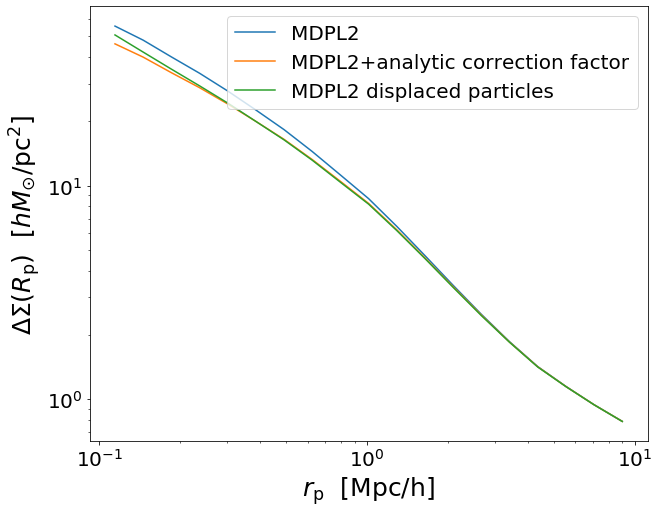

In [17]:
plt.figure(figsize=[10,8])
plt.plot(rbin,ds_in_pc, label='MDPL2')
plt.plot(rbin, ds_baryons_in_pc, label='MDPL2+analytic correction factor')
plt.plot(rbin, ds_displaced_in_pc, label='MDPL2 displaced particles')
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

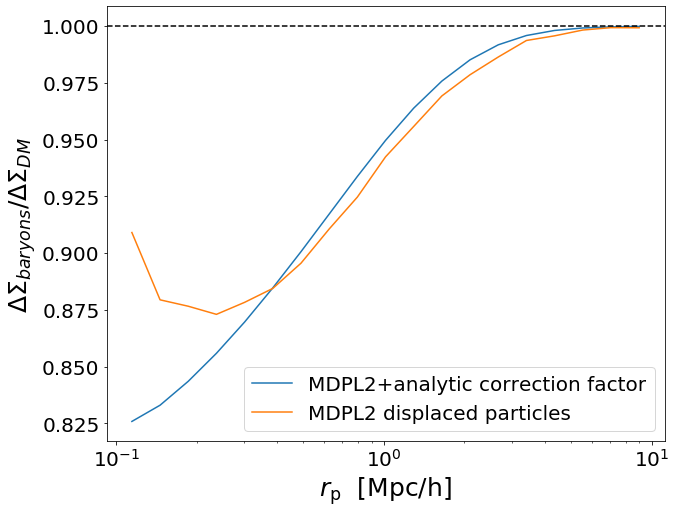

In [18]:
plt.figure(figsize=[10,8])
plt.plot(rbin, ds_baryons_in_pc/ds_in_pc, label='MDPL2+analytic correction factor')
plt.plot(rbin, ds_displaced_in_pc/ds_in_pc, label='MDPL2 displaced particles')
plt.axhline(1, linestyle='--', color='k')
plt.semilogx()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc/h]}$', fontsize=25)
plt.ylabel(r'$\Delta\Sigma_{baryons}/\Delta\Sigma_{DM}$', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.show()

In [122]:
ds_baryons_in_pc/ds_in_pc - ds_displaced_in_pc/ds_in_pc

array([-0.08053466, -0.04444691, -0.03180621, -0.01644385, -0.00838793,
        0.00017029,  0.00494729,  0.00658701,  0.00945092,  0.00815974,
        0.00958023,  0.00865462,  0.00921274,  0.00824122,  0.00495115,
        0.00475081,  0.00279011,  0.00172845,  0.00156031])

## Main changes:
- in `DeltaSigmas_from_density_profile()`, extended integration bound past max(rbin) to 200Mpc/h
- in `predict_with_baryons()` added new radial range for calculating density profile in `bfc.profiles()` called `rho_r` that extends beyond (both larger and smaller) the radial bins used for Delta Sigma (`rbin`)
- added Diemer&Joyce2019 concentration model from `colossus`
- checked to see if artificially increasing the concentration by 7% would help (suggested by an den Bosch et al. 2013), but it didn't